In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path

In [51]:
RAW_DATA_PATH = r"/home/dpolak/Downloads/IXI_dataset/"
PROCESSED_DATA_PATH = r"/home/dpolak/Downloads/IXI_output/"

# Original scans

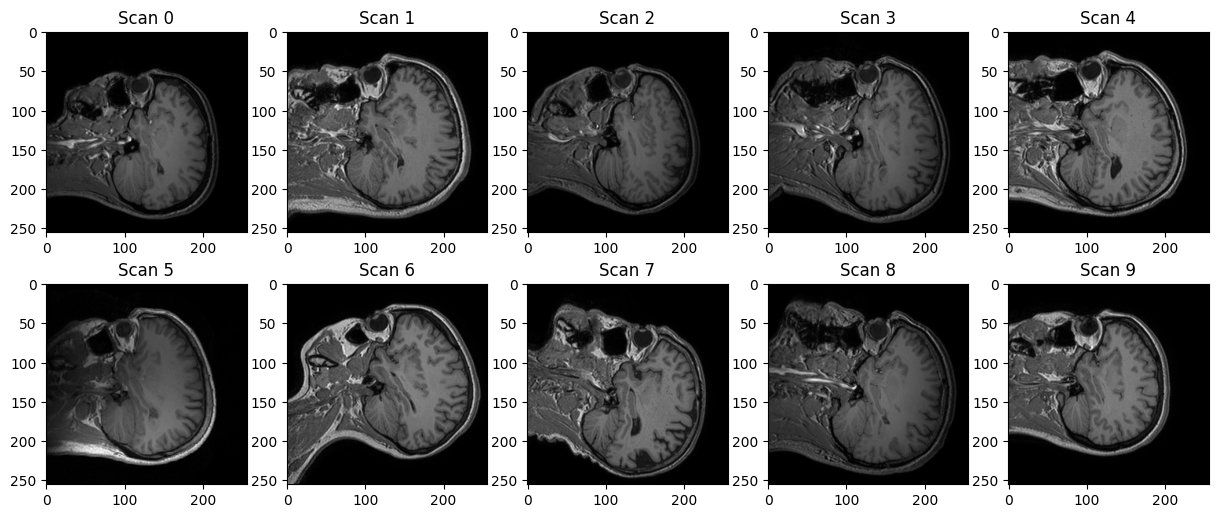

In [9]:
#Plot ten random scans
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    img = nib.load(str(np.random.choice(list(Path(RAW_DATA_PATH).glob("*.nii.gz")))))
    data = img.get_fdata()
    ax.imshow(data[:, :, 50], cmap="gray")
    ax.set_title(f"Scan {i}")

In [ ]:
mean_values = []
max_values = []
for scan in Path(RAW_DATA_PATH).glob("*.nii.gz"):
    img = nib.load(str(scan))
    data = img.get_fdata()
    mean_values.append(np.mean(data))
    max_values.append(np.max(data))

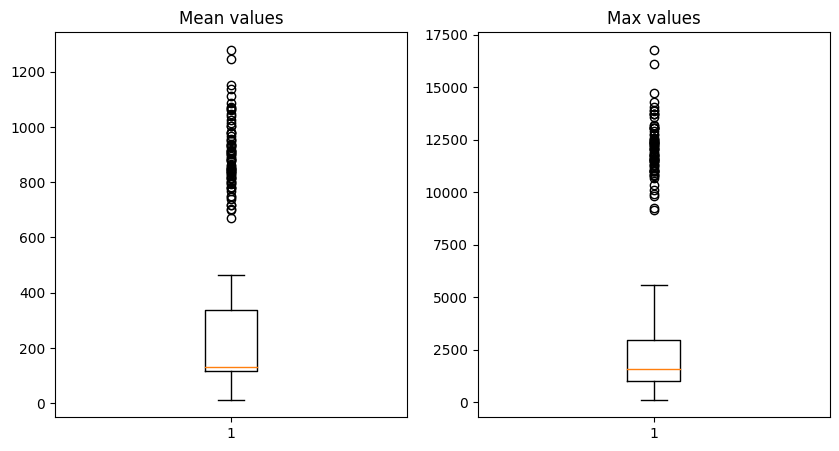

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.boxplot(mean_values)
ax1.set_title("Mean values")
ax2.boxplot(max_values)
ax2.set_title("Max values")
plt.show()

### Histogram intensity rescaling

In [34]:
def rescale_intensity(volume: np.ndarray, percentiles: tuple[float, float] = (0.5, 99.5),
                      bins_num: int = 256) -> np.ndarray:
    """
    Rescale the intensity of the image volume.

    Quantize the image volume into bins_num bins and map them to the corresponding intensity values.
    Borrowed from https://github.com/quqixun/BrainPrep/tree/master
    :param volume: Image volume to be rescaled.
    :param percentiles: Lower and upper percentiles for rescaling. Defines min and max values.
    :param bins_num: Number of bins to use for rescaling. If 0, use simple min-max normalization.
    :return: Rescaled image volume.
    """
    obj_volume = volume[np.where(volume > 0)]
    min_value = np.percentile(obj_volume, percentiles[0])
    max_value = np.percentile(obj_volume, percentiles[1])

    if bins_num == 0:
        obj_volume = (obj_volume - min_value) / (max_value - min_value).astype(np.float32)
    else:
        obj_volume = np.round((obj_volume - min_value) / (max_value - min_value) * (bins_num - 1))
        obj_volume[np.where(obj_volume < 1)] = 1
        obj_volume[np.where(obj_volume > (bins_num - 1))] = bins_num - 1

    volume = volume.astype(obj_volume.dtype)
    volume[np.where(volume > 0)] = obj_volume

    return volume

In [37]:
mean_values = []
max_values = []
for scan in Path(RAW_DATA_PATH).glob("*.nii.gz"):
    img = nib.load(str(scan))
    data = rescale_intensity(img.get_fdata())
    mean_values.append(np.mean(data))
    max_values.append(np.max(data))

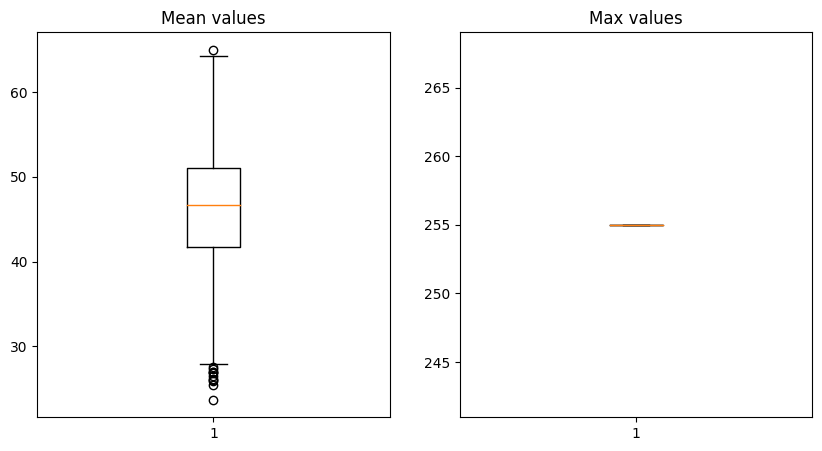

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.boxplot(mean_values)
ax1.set_title("Mean values")
ax2.boxplot(max_values)
ax2.set_title("Max values")
plt.show()

## Skull stripping

In [47]:
image_before_path = r"/home/dpolak/Downloads/IXI_output/IXI002-Guys-0828-T1/mri/orig.mgz"
image_after_path = r"/home/dpolak/Downloads/IXI_output/IXI002-Guys-0828-T1/mri/brainmask.nii.gz"
mask_path = r"/home/dpolak/Downloads/IXI_output/IXI002-Guys-0828-T1/mri/mask.mgz"

In [49]:
image_before = nib.load(image_before_path).get_fdata()
image_after = nib.load(image_after_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

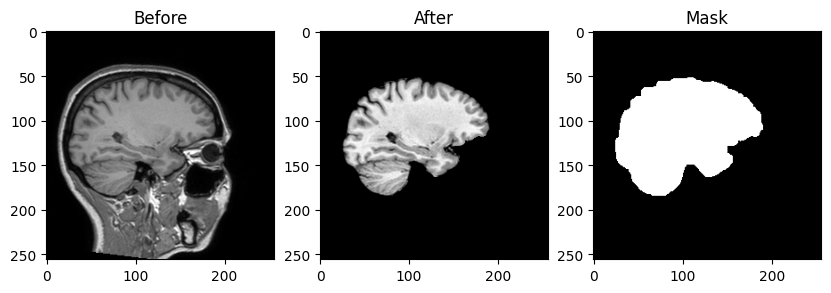

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image_before[100, :, :], cmap="gray")
axs[0].set_title("Before")
axs[1].imshow(image_after[100, :, :], cmap="gray")
axs[1].set_title("After")
axs[2].imshow(mask[100, :, :], cmap="gray")
axs[2].set_title("Mask")
plt.show()

## Registration

/tmp/ipykernel_6901/482650873.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 10, i + 11)


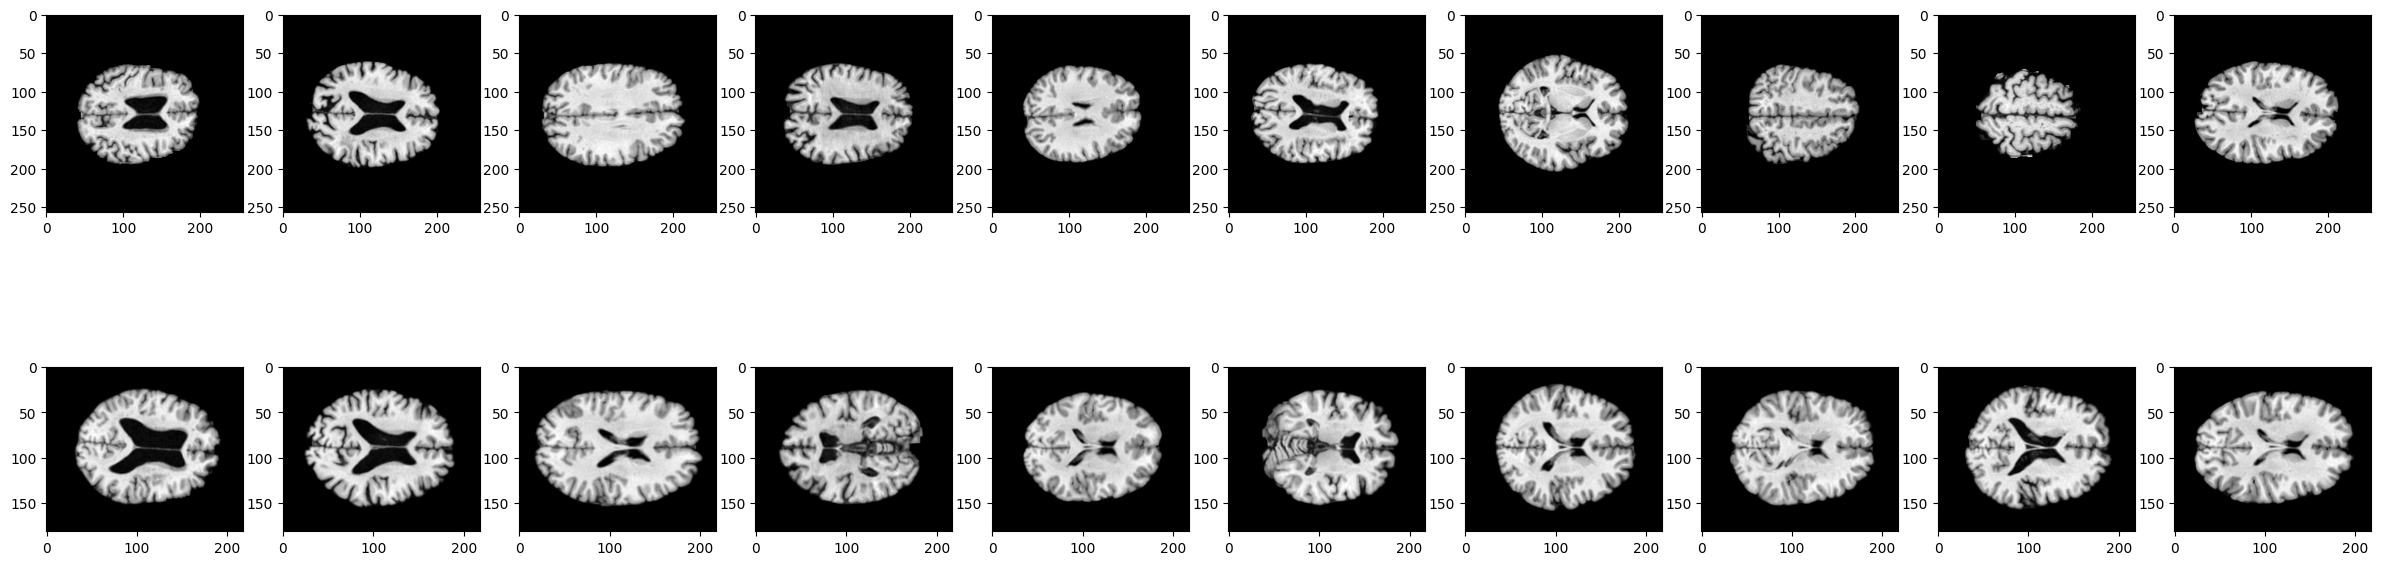

In [75]:
subjects = Path(PROCESSED_DATA_PATH).glob(r"*/mri")
plt.figure(figsize=(30, 8))
for i, subject in enumerate(subjects):
    if i == 10:
        break
    subject = str(subject)
    image_before = nib.load(subject + "/brainmask.nii.gz").get_fdata()
    image_after = nib.load(subject + "/brainmask_registered.nii.gz").get_fdata()
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_before[:, 90, :], cmap="gray")
    plt.axes().set_aspect("equal")
    plt.subplot(2, 10, i + 11)
    plt.imshow(image_after[:, :, 90], cmap="gray")
plt.show()

In [101]:
subjects = list(Path(PROCESSED_DATA_PATH).glob(r"*/mri"))
image_before = np.zeros((256, 256, 1))
image_after = np.zeros((182, 218, 1))
for subject in subjects:
    subject = str(subject)
    image_before += np.expand_dims(nib.load(subject + "/brainmask.nii.gz").get_fdata()[:256, 90, :256], axis=-1)
    image_after += np.expand_dims(nib.load(subject + "/brainmask_registered.nii.gz").get_fdata()[:182, :218, 90], axis=-1)
image_before /= len(subjects)
image_after /= len(subjects)

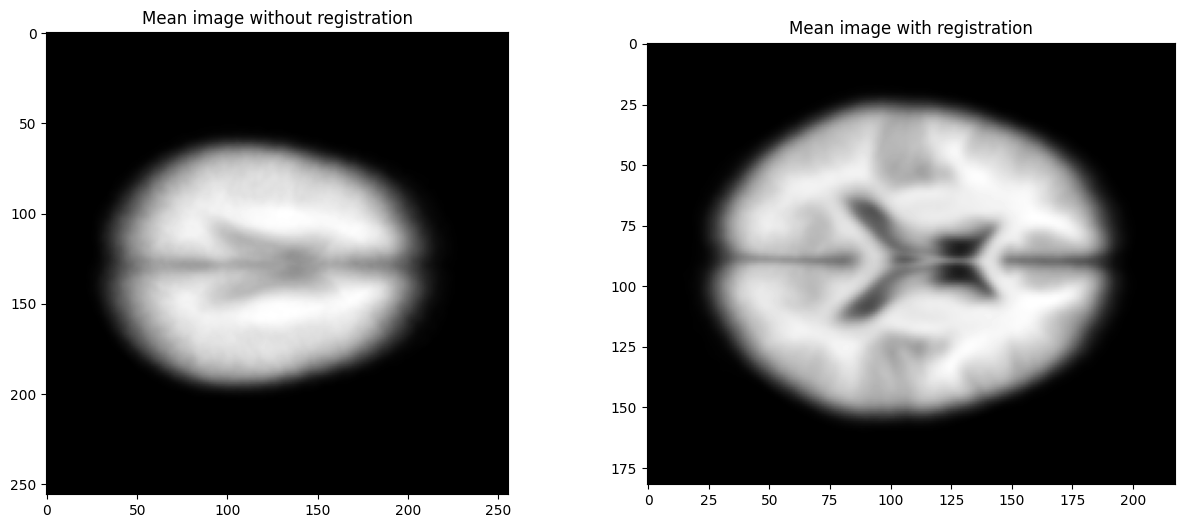

In [103]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_before[:, :, 0], cmap="gray")
plt.title("Mean image without registration")
plt.subplot(1, 2, 2)
plt.imshow(image_after[:, :, 0], cmap="gray")
plt.title("Mean image with registration")
plt.show()

## N4 bias correction

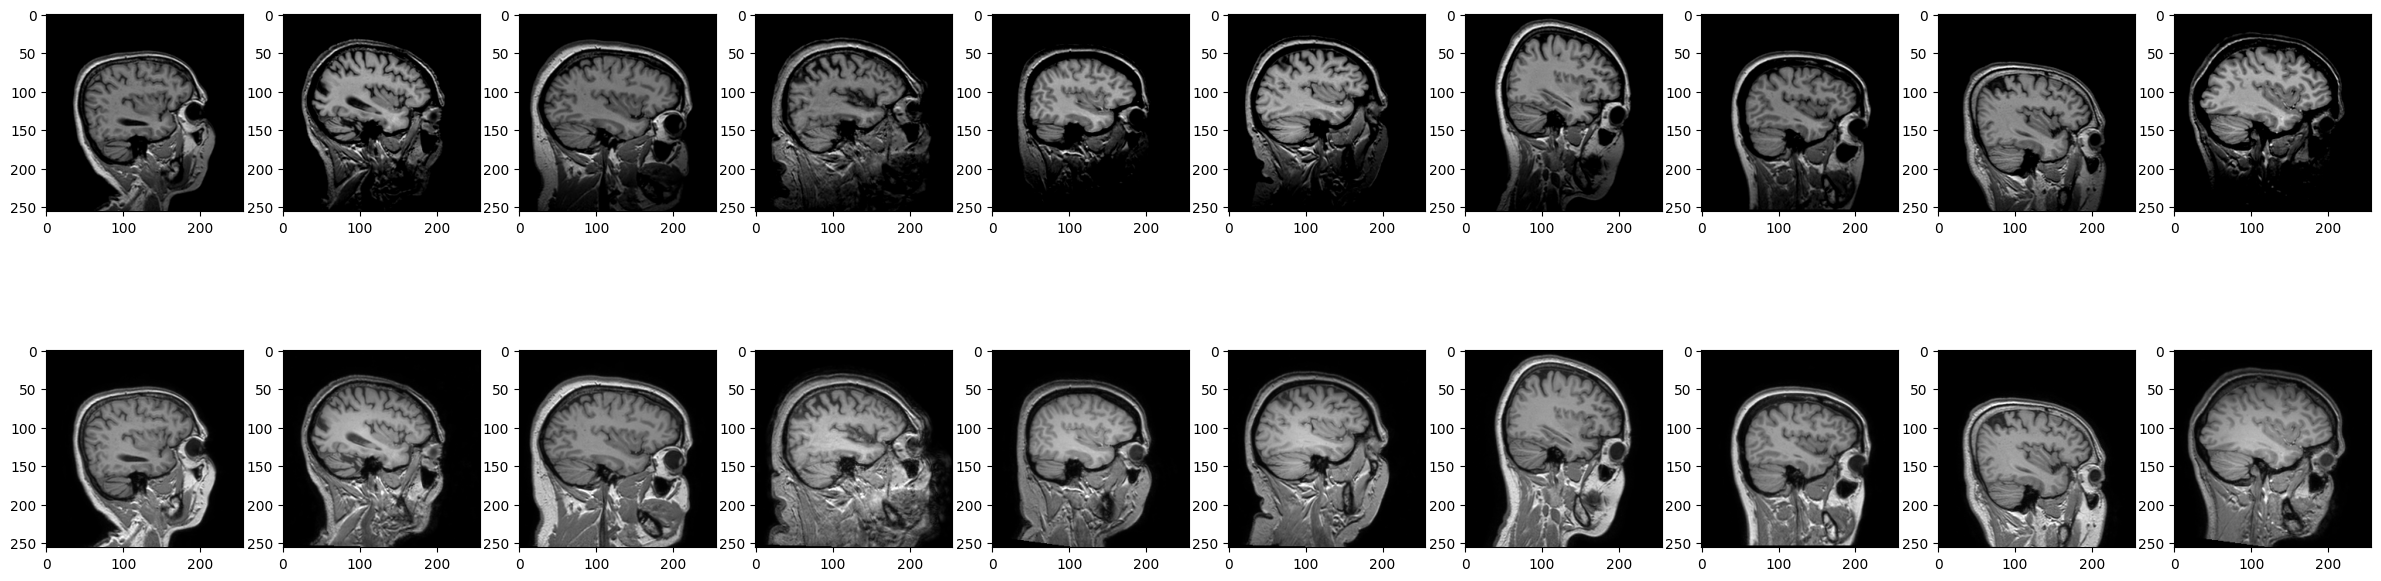

In [108]:
subjects = Path(PROCESSED_DATA_PATH).glob(r"*/mri")
plt.figure(figsize=(30, 8))
for i, subject in enumerate(subjects):
    if i == 10:
        break
    subject = str(subject)
    image_before = nib.load(subject + "/orig.mgz").get_fdata()
    image_after = nib.load(subject + "/orig_nu.mgz").get_fdata()
    plt.subplot(2, 10, i + 11)
    plt.imshow(image_before[90, :, :], cmap="gray")
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_after[90, :, :], cmap="gray")

## Denoising

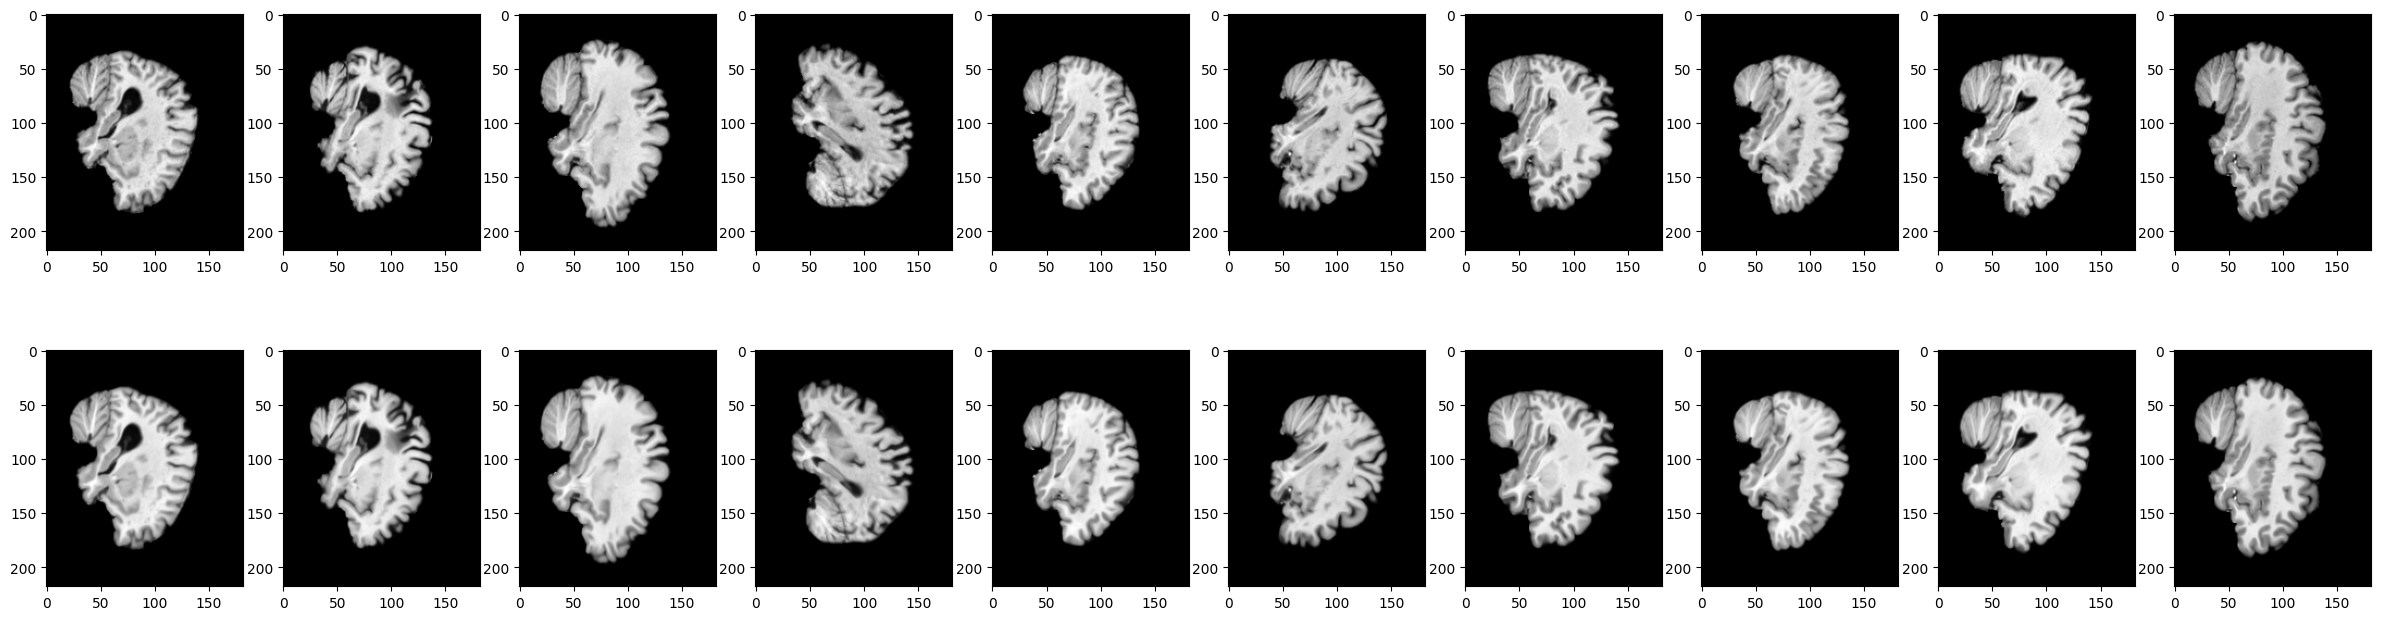

In [111]:
subjects = Path(PROCESSED_DATA_PATH).glob(r"*/mri")
plt.figure(figsize=(30, 8))
for i, subject in enumerate(subjects):
    if i == 10:
        break
    subject = str(subject)
    image_before = nib.load(subject + "/brainmask_registered.nii.gz").get_fdata()
    image_after = nib.load(subject + "/antsdn.brain_final.nii.gz").get_fdata()
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_before[120, :, :], cmap="gray")
    plt.subplot(2, 10, i + 11)
    plt.imshow(image_after[120, :, :], cmap="gray")
